In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2014-09-19,92.70,99.70,89.95,93.89,271831625,0
1,2014-09-22,92.70,92.95,89.50,89.89,66628862,0
2,2014-09-23,89.00,90.48,86.62,87.17,38984872,0
3,2014-09-24,88.47,90.57,87.22,90.57,32016559,0
4,2014-09-25,91.09,91.50,88.50,88.92,28584828,0


**Add Bloomberg ref info to create ticker lookup table**

In [3]:
def bbg_ref():
    
    tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

    from os import listdir
    from os.path import isfile, join

    mypath = 'Stocks/'

    tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 

    for i in range(len(tickers)):
        raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
        year = raw_data.iloc[-1]['Date'][:4]
        n_datapoints = len(raw_data)
        tickers.loc[i,'year_last'] = year
        tickers.loc[i,'n_datapoints'] = n_datapoints

        tickers['year_last'] = tickers['year_last'].astype(int)
        tickers = tickers[~tickers['file_name'].str.contains('_')]
        tickers = tickers[~tickers['file_name'].str.contains('-')]
    
    import pdblp
    
    con = pdblp.BCon(debug=True, port=8194, timeout=5000)

    tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

    con.start()

    ref_data = pd.DataFrame()

    for ticker in tickers_['ticker'].tolist():
        try:
            ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
        except:
            True
    ref_data_copy = ref_data
    ref_data.pivot(index='ticker',columns='field',values='value')
    tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
    tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]
    
    tickers.to_csv('tickers_lookup.csv',index=False)

**Feature extraction**

In [4]:
def create_features(ticker,trading_window=21):
    #Function to calculate useful statistics from raw data
    #Trading window in working days
    
    import numpy as np
    import pandas as pd
    
    raw_data = pd.read_csv('Stocks/' + ticker + '.txt')
    raw_data.set_index('Date',inplace = True)
    
    features = pd.DataFrame(index=raw_data.index)
    
    features['Open'] = raw_data['Open']
    
    #Close std
    #features['std_q_tw'] = raw_data['Close'].shift(1).rolling(int((1/4)*trading_window)).std()
    #features['std_h_tw'] = raw_data['Close'].shift(1).rolling(int((1/2)*trading_window)).std()
    #features['std_tw'] = raw_data['Close'].shift(1).rolling(int((1)*trading_window)).std()
    #features['std_21_d'] = raw_data['Close'].shift(1).rolling(21).std()
    #features['std_tw'] = raw_data['Close'].shift(1).rolling(trading_window).std()
    #features['std_4tw'] = raw_data['Close'].shift(1).rolling(4*trading_window).std()
    
    #Overnight pct (Open_t - Close_t-1)
    features['pct_overnight'] = raw_data['Open'].div(raw_data['Close'].shift(1)) - 1
    
    #Close pct (Close - Close) & Close - Close std
    features['pct_close'] = raw_data['Close'].shift(1).div(raw_data['Close'].shift(2)) - 1
    
    features['pct_close_sigma_q_tw'] = features['pct_close'].div(features['pct_close'].rolling(int((1/4)*trading_window)).std())
    #features['pct_close_sigma_h_tw'] = features['pct_close'].div(features['pct_close'].rolling(int((1/2)*trading_window)).std())
    features['pct_close_sigma_tw'] = features['pct_close'].div(features['pct_close'].rolling(int((1)*trading_window)).std())                                                                         
    #features['pct_close_sigma_21'] = features['pct_close'].div(features['pct_close'].rolling(21).std())
    #features['pct_close_sigma_tw'] = features['pct_close'].div(features['pct_close'].rolling(trading_window).std())
    #features['pct_close_sigma_4tw'] = features['pct_close'].div(features['pct_close'].rolling(4*trading_window).std())
    
    #Average close return (Momentum)
    
    features['avg_return_q_tw'] = features['pct_close'].rolling(int((1/4)*trading_window)).mean()
    #features['avg_return_h_tw'] = features['pct_close'].rolling(int((1/2)*trading_window)).mean()
    features['avg_return_tw'] = features['pct_close'].rolling(int((1)*trading_window)).mean() 
                                                                                                   
    #features['avg_return_21'] = features['pct_close'].rolling(21).mean()
    #features['avg_return_tw'] = features['pct_close'].rolling(trading_window).mean()
    #features['avg_return_4tw'] = features['pct_close'].rolling(4*trading_window).mean()
    
    #Open percentile
    def rank(array):
        s = pd.Series(array)
        return s.rank(ascending=True,pct=True)[len(s)-1]
    
    features['perctentile_h_tw'] = features['Open'].rolling(int((1/2)*trading_window)).apply(rank,raw=False)
    features['perctentile_tw'] = features['Open'].rolling(int((1)*trading_window)).apply(rank,raw=False)    
                                                   
    #features['perctentile_tw'] = features['Open'].rolling(trading_window).apply(rank,raw=False)
    #features['perctentile_4tw'] = features['Open'].rolling(4*trading_window).apply(rank,raw=False)
    
    #Volume
    features['pct_volume'] = raw_data['Volume'].shift(1).div(raw_data['Volume'].shift(2)) - 1
    
    features['pct_volume_sigma_q_tw'] = features['pct_volume'].div(features['pct_volume'].rolling(int((1/4)*trading_window)).std())
    #features['pct_volume_sigma_h_tw'] = features['pct_volume'].div(features['pct_volume'].rolling(int((1/2)*trading_window)).std())
    features['pct_volume_sigma_tw'] = features['pct_volume'].div(features['pct_volume'].rolling(int((1)*trading_window)).std())                                                                                              
                                                   
    #features['pct_volume_sigma_21'] = features['pct_volume'].div(features['pct_volume'].rolling(21).std())
    #features['pct_volume_sigma_tw'] = features['pct_volume'].div(features['pct_volume'].rolling(trading_window).std())
    #features['pct_volume_sigma_4tw'] = features['pct_volume'].div(features['pct_volume'].rolling(4*trading_window).std())
    
    features.drop('pct_volume',axis=1,inplace = True)
    
    #Remove rows with na features
    features.dropna(inplace=True)
    
    return features, raw_data

In [5]:
features, raw_data = create_features('ba.us',21)

In [6]:
features.shape

(12031, 11)

In [7]:
def sample_data(trading_window,features, raw_data):
    #Keep random sample of size trading_window  
    import numpy as np
    i = np.random.randint(0,high=len(features)-trading_window-1)
    features = features.iloc[i:i+trading_window,] 
    prices= raw_data.loc[features.index,]
    return features, prices

In [8]:
features, prices = sample_data(5, features, raw_data)

**Reinforcement Learning**

In [9]:
import gym
import gym_market
import numpy as np

ticker = 'ba.us'
trading_window = 21
pos_limit = 2
trading_freq = 1

features, raw_data = create_features(ticker,trading_window)

features['Year'] = pd.to_datetime(features.index.values).year
features = features.loc[features['Year']> 2007]
raw_data = raw_data.loc[features.index]
features.drop(['Year'], inplace = True, axis = 1)

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'ticker': ticker,
                  'features': features, 
                  'raw_data':raw_data}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


C:\Users\Alex\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
features.columns

Index(['Open', 'pct_overnight', 'pct_close', 'pct_close_sigma_q_tw',
       'pct_close_sigma_tw', 'avg_return_q_tw', 'avg_return_tw',
       'perctentile_h_tw', 'perctentile_tw', 'pct_volume_sigma_q_tw',
       'pct_volume_sigma_tw'],
      dtype='object')

Test environment:

In [11]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [2, 2, 0, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 0, 2, 0, 2, 1, 1, 1, 1]
Rewards: [1.669, 0.23700000000000004, -0.7649999999999999, -0.7669999999999999, -1.8199999999999998, 0.14900000000000005, -1.88, -1.9109999999999998, -1.9429999999999998, 5.551115123125783e-17, -2.0309999999999997, -1.032, -1.033, -1.0339999999999998, -0.05999999999999994, 0.33999999999999997, -0.6910000000000001, 1.28, -0.751, -2.183, -1.185]
Return: 0.9215477359462345


In [12]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

***Training:***

Neural net architecture:

In [13]:
import tensorflow as tf 

class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [14]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [15]:
train_episodes = 3000         # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.7                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.00005         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [16]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, state_size=features.shape[1]+2, learning_rate=learning_rate)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Populate memory:

In [17]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [18]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()    
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                #if ep > 1500:
                    #print("Q_s: "+str(Qs))
                action = np.argmax(Qs)
            #print(action)if ep > 1500 else False
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: -10.841999999999997 Training loss: 112.6436 Explore P: 0.9979 Total return: 0.91
Episode: 2 Total reward: -0.04399999999999937 Training loss: 150.7299 Explore P: 0.9959 Total return: 1.03
Episode: 3 Total reward: 6.828000000000001 Training loss: 60.4375 Explore P: 0.9938 Total return: 0.88
Episode: 4 Total reward: -15.394999999999996 Training loss: 59.7515 Explore P: 0.9917 Total return: 1.04
Episode: 5 Total reward: -6.191999999999998 Training loss: 64.0162 Explore P: 0.9897 Total return: 1.03
Episode: 6 Total reward: 5.757000000000001 Training loss: 37.7034 Explore P: 0.9876 Total return: 1.02
Episode: 7 Total reward: 1.3620000000000019 Training loss: 4.3909 Explore P: 0.9856 Total return: 0.85
Episode: 8 Total reward: 9.241000000000001 Training loss: 15.7999 Explore P: 0.9835 Total return: 1.02
Episode: 9 Total reward: 1.3340000000000005 Training loss: 8.0115 Explore P: 0.9815 Total return: 1.07
Episode: 10 Total reward: -8.699 Training loss: 11.8053 Explore

Episode: 84 Total reward: -1.1370000000000018 Training loss: 1.5797 Explore P: 0.8399 Total return: 0.95
Episode: 85 Total reward: -10.807999999999998 Training loss: 1.2203 Explore P: 0.8382 Total return: 0.99
Episode: 86 Total reward: -9.592 Training loss: 0.8684 Explore P: 0.8364 Total return: 1.00
Episode: 87 Total reward: -12.023000000000001 Training loss: 1.6880 Explore P: 0.8347 Total return: 1.00
Episode: 88 Total reward: -5.948999999999999 Training loss: 0.9023 Explore P: 0.8330 Total return: 1.04
Episode: 89 Total reward: 5.211999999999999 Training loss: 1.6340 Explore P: 0.8312 Total return: 0.99
Episode: 90 Total reward: -14.346000000000002 Training loss: 0.8761 Explore P: 0.8295 Total return: 0.88
Episode: 91 Total reward: 8.023 Training loss: 1.0886 Explore P: 0.8278 Total return: 1.09
Episode: 92 Total reward: -5.534999999999999 Training loss: 0.9715 Explore P: 0.8261 Total return: 0.88
Episode: 93 Total reward: -8.019 Training loss: 1.0945 Explore P: 0.8244 Total return:

Episode: 168 Total reward: 10.713000000000001 Training loss: 0.8233 Explore P: 0.7057 Total return: 0.97
Episode: 169 Total reward: -12.495999999999999 Training loss: 1.4515 Explore P: 0.7042 Total return: 1.06
Episode: 170 Total reward: -15.719000000000003 Training loss: 1.0195 Explore P: 0.7028 Total return: 1.04
Episode: 171 Total reward: 3.853 Training loss: 1.1182 Explore P: 0.7013 Total return: 0.99
Episode: 172 Total reward: 2.7070000000000007 Training loss: 1.3663 Explore P: 0.6999 Total return: 1.06
Episode: 173 Total reward: 2.4469999999999996 Training loss: 0.7284 Explore P: 0.6984 Total return: 0.99
Episode: 174 Total reward: 5.587000000000001 Training loss: 0.8040 Explore P: 0.6970 Total return: 0.91
Episode: 175 Total reward: -11.491 Training loss: 0.7999 Explore P: 0.6955 Total return: 0.97
Episode: 176 Total reward: -20.739000000000004 Training loss: 0.9055 Explore P: 0.6941 Total return: 0.97
Episode: 177 Total reward: -6.977000000000002 Training loss: 0.8921 Explore P

Episode: 251 Total reward: 8.042 Training loss: 1.1944 Explore P: 0.5944 Total return: 0.96
Episode: 252 Total reward: -6.257 Training loss: 0.6476 Explore P: 0.5932 Total return: 0.99
Episode: 253 Total reward: 7.116 Training loss: 0.7421 Explore P: 0.5920 Total return: 1.00
Episode: 254 Total reward: -0.7559999999999998 Training loss: 1.1085 Explore P: 0.5907 Total return: 1.02
Episode: 255 Total reward: 4.770999999999999 Training loss: 1.1409 Explore P: 0.5895 Total return: 0.99
Episode: 256 Total reward: -12.881 Training loss: 1.2902 Explore P: 0.5883 Total return: 0.89
Episode: 257 Total reward: -0.09099999999999886 Training loss: 1.3283 Explore P: 0.5871 Total return: 1.01
Episode: 258 Total reward: 9.54 Training loss: 1.1227 Explore P: 0.5859 Total return: 1.14
Episode: 259 Total reward: 0.5369999999999993 Training loss: 1.2832 Explore P: 0.5847 Total return: 0.86
Episode: 260 Total reward: 9.913 Training loss: 0.9182 Explore P: 0.5835 Total return: 1.13
Episode: 261 Total rewar

Episode: 335 Total reward: 7.2509999999999994 Training loss: 0.9530 Explore P: 0.4999 Total return: 0.97
Episode: 336 Total reward: -2.752 Training loss: 1.2085 Explore P: 0.4989 Total return: 0.92
Episode: 337 Total reward: -4.007000000000001 Training loss: 1.4818 Explore P: 0.4978 Total return: 1.05
Episode: 338 Total reward: 10.700000000000001 Training loss: 1.0452 Explore P: 0.4968 Total return: 1.18
Episode: 339 Total reward: 2.7259999999999995 Training loss: 0.7092 Explore P: 0.4958 Total return: 1.11
Episode: 340 Total reward: -1.835000000000001 Training loss: 1.3447 Explore P: 0.4948 Total return: 0.95
Episode: 341 Total reward: 7.698 Training loss: 1.3479 Explore P: 0.4938 Total return: 1.11
Episode: 342 Total reward: -18.141999999999996 Training loss: 1.3317 Explore P: 0.4928 Total return: 0.70
Episode: 343 Total reward: 8.589000000000002 Training loss: 1.1916 Explore P: 0.4917 Total return: 1.24
Episode: 344 Total reward: -23.326999999999998 Training loss: 1.5786 Explore P: 

Episode: 418 Total reward: 9.485000000000001 Training loss: 1.2672 Explore P: 0.4215 Total return: 1.03
Episode: 419 Total reward: 0.04000000000000037 Training loss: 0.9920 Explore P: 0.4207 Total return: 1.09
Episode: 420 Total reward: 11.719999999999999 Training loss: 1.2877 Explore P: 0.4198 Total return: 1.08
Episode: 421 Total reward: 6.629 Training loss: 1.2347 Explore P: 0.4190 Total return: 1.24
Episode: 422 Total reward: -13.927999999999997 Training loss: 0.7112 Explore P: 0.4181 Total return: 0.96
Episode: 423 Total reward: -14.400999999999998 Training loss: 1.6925 Explore P: 0.4172 Total return: 0.84
Episode: 424 Total reward: 10.456999999999999 Training loss: 1.2934 Explore P: 0.4164 Total return: 1.06
Episode: 425 Total reward: 11.961999999999998 Training loss: 1.5019 Explore P: 0.4155 Total return: 1.03
Episode: 426 Total reward: 11.149000000000001 Training loss: 1.1148 Explore P: 0.4147 Total return: 0.92
Episode: 427 Total reward: 8.433 Training loss: 1.1183 Explore P: 

Episode: 502 Total reward: -5.696999999999999 Training loss: 1.3498 Explore P: 0.3550 Total return: 0.97
Episode: 503 Total reward: -12.77 Training loss: 1.2465 Explore P: 0.3543 Total return: 0.88
Episode: 504 Total reward: 6.557999999999999 Training loss: 0.5497 Explore P: 0.3535 Total return: 1.11
Episode: 505 Total reward: 13.353 Training loss: 0.9070 Explore P: 0.3528 Total return: 1.22
Episode: 506 Total reward: -2.6409999999999982 Training loss: 1.0537 Explore P: 0.3521 Total return: 1.14
Episode: 507 Total reward: -12.567000000000002 Training loss: 1.2613 Explore P: 0.3514 Total return: 0.98
Episode: 508 Total reward: -5.7170000000000005 Training loss: 1.2196 Explore P: 0.3507 Total return: 0.73
Episode: 509 Total reward: -5.031000000000001 Training loss: 0.8152 Explore P: 0.3500 Total return: 1.03
Episode: 510 Total reward: 0.4140000000000006 Training loss: 1.1787 Explore P: 0.3492 Total return: 1.11
Episode: 511 Total reward: -15.616 Training loss: 0.8082 Explore P: 0.3485 To

Episode: 584 Total reward: -8.491 Training loss: 0.7028 Explore P: 0.3004 Total return: 1.04
Episode: 585 Total reward: 6.763000000000002 Training loss: 1.2960 Explore P: 0.2998 Total return: 1.03
Episode: 586 Total reward: 10.829 Training loss: 0.8780 Explore P: 0.2992 Total return: 1.31
Episode: 587 Total reward: -6.495 Training loss: 0.8231 Explore P: 0.2986 Total return: 0.79
Episode: 588 Total reward: 13.0 Training loss: 0.7913 Explore P: 0.2980 Total return: 1.05
Episode: 589 Total reward: -6.829999999999998 Training loss: 0.6647 Explore P: 0.2974 Total return: 0.92
Episode: 590 Total reward: -8.570999999999998 Training loss: 1.1394 Explore P: 0.2968 Total return: 0.97
Episode: 591 Total reward: -1.619 Training loss: 0.7173 Explore P: 0.2962 Total return: 0.87
Episode: 592 Total reward: 2.345000000000001 Training loss: 1.7456 Explore P: 0.2956 Total return: 1.04
Episode: 593 Total reward: 4.1400000000000015 Training loss: 1.1877 Explore P: 0.2950 Total return: 0.86
Episode: 594 T

Episode: 666 Total reward: 6.386 Training loss: 0.7210 Explore P: 0.2545 Total return: 1.15
Episode: 667 Total reward: 8.012999999999998 Training loss: 0.7721 Explore P: 0.2540 Total return: 0.90
Episode: 668 Total reward: -1.0249999999999997 Training loss: 1.3326 Explore P: 0.2534 Total return: 1.11
Episode: 669 Total reward: 13.837000000000002 Training loss: 0.9061 Explore P: 0.2529 Total return: 1.18
Episode: 670 Total reward: -13.305 Training loss: 1.2879 Explore P: 0.2524 Total return: 0.90
Episode: 671 Total reward: 8.989 Training loss: 1.1420 Explore P: 0.2519 Total return: 1.02
Episode: 672 Total reward: 3.304000000000001 Training loss: 0.7553 Explore P: 0.2514 Total return: 1.01
Episode: 673 Total reward: -22.015999999999995 Training loss: 1.0027 Explore P: 0.2509 Total return: 0.51
Episode: 674 Total reward: 6.300000000000002 Training loss: 0.9946 Explore P: 0.2504 Total return: 1.02
Episode: 675 Total reward: -16.873 Training loss: 0.7915 Explore P: 0.2499 Total return: 0.79

Episode: 748 Total reward: -5.053999999999999 Training loss: 1.3291 Explore P: 0.2158 Total return: 1.02
Episode: 749 Total reward: -7.05 Training loss: 0.9980 Explore P: 0.2154 Total return: 1.05
Episode: 750 Total reward: 5.678 Training loss: 0.5374 Explore P: 0.2149 Total return: 1.08
Episode: 751 Total reward: -13.06 Training loss: 1.0410 Explore P: 0.2145 Total return: 0.79
Episode: 752 Total reward: -1.0370000000000008 Training loss: 0.7727 Explore P: 0.2141 Total return: 1.00
Episode: 753 Total reward: 7.244 Training loss: 1.2906 Explore P: 0.2137 Total return: 1.11
Episode: 754 Total reward: -20.612 Training loss: 1.4435 Explore P: 0.2132 Total return: 0.91
Episode: 755 Total reward: -18.423000000000002 Training loss: 0.6394 Explore P: 0.2128 Total return: 0.71
Episode: 756 Total reward: -20.367999999999995 Training loss: 1.0650 Explore P: 0.2124 Total return: 0.71
Episode: 757 Total reward: -9.889 Training loss: 1.1397 Explore P: 0.2119 Total return: 0.80
Episode: 758 Total re

Episode: 830 Total reward: 8.808 Training loss: 1.1756 Explore P: 0.1832 Total return: 1.04
Episode: 831 Total reward: -17.511000000000003 Training loss: 0.9102 Explore P: 0.1829 Total return: 0.85
Episode: 832 Total reward: -10.126000000000001 Training loss: 0.8799 Explore P: 0.1825 Total return: 1.04
Episode: 833 Total reward: -4.3709999999999996 Training loss: 0.7714 Explore P: 0.1822 Total return: 0.96
Episode: 834 Total reward: 11.289 Training loss: 0.9044 Explore P: 0.1818 Total return: 1.09
Episode: 835 Total reward: -5.103999999999999 Training loss: 1.6521 Explore P: 0.1814 Total return: 0.93
Episode: 836 Total reward: -2.3709999999999996 Training loss: 0.9994 Explore P: 0.1811 Total return: 0.98
Episode: 837 Total reward: -8.812000000000001 Training loss: 1.0216 Explore P: 0.1807 Total return: 0.97
Episode: 838 Total reward: 10.024000000000001 Training loss: 0.8762 Explore P: 0.1804 Total return: 1.05
Episode: 839 Total reward: 9.158 Training loss: 0.8253 Explore P: 0.1800 Tot

Episode: 912 Total reward: 10.241999999999999 Training loss: 0.6587 Explore P: 0.1558 Total return: 1.01
Episode: 913 Total reward: -8.908999999999999 Training loss: 1.1438 Explore P: 0.1555 Total return: 0.87
Episode: 914 Total reward: -15.307000000000002 Training loss: 0.6773 Explore P: 0.1552 Total return: 0.54
Episode: 915 Total reward: -3.0139999999999993 Training loss: 1.4298 Explore P: 0.1549 Total return: 0.88
Episode: 916 Total reward: -1.344999999999999 Training loss: 0.7914 Explore P: 0.1546 Total return: 1.01
Episode: 917 Total reward: -2.848000000000001 Training loss: 1.0770 Explore P: 0.1543 Total return: 0.94
Episode: 918 Total reward: 8.745000000000001 Training loss: 0.6860 Explore P: 0.1540 Total return: 0.92
Episode: 919 Total reward: -16.757 Training loss: 1.1249 Explore P: 0.1537 Total return: 0.93
Episode: 920 Total reward: 7.181000000000003 Training loss: 0.9270 Explore P: 0.1534 Total return: 1.03
Episode: 921 Total reward: 3.223999999999999 Training loss: 0.9544

Episode: 995 Total reward: 10.540000000000003 Training loss: 0.7126 Explore P: 0.1325 Total return: 1.11
Episode: 996 Total reward: 13.248999999999999 Training loss: 0.8796 Explore P: 0.1323 Total return: 1.21
Episode: 997 Total reward: -15.873999999999999 Training loss: 0.5160 Explore P: 0.1320 Total return: 0.86
Episode: 998 Total reward: -4.051 Training loss: 1.0862 Explore P: 0.1317 Total return: 1.19
Episode: 999 Total reward: -0.3959999999999986 Training loss: 0.7176 Explore P: 0.1315 Total return: 0.97
Episode: 1000 Total reward: 2.5180000000000007 Training loss: 0.8440 Explore P: 0.1312 Total return: 0.99
Episode: 1001 Total reward: -8.911999999999999 Training loss: 0.9946 Explore P: 0.1310 Total return: 1.02
Episode: 1002 Total reward: 5.890999999999999 Training loss: 1.1516 Explore P: 0.1307 Total return: 1.07
Episode: 1003 Total reward: -4.463999999999999 Training loss: 0.9018 Explore P: 0.1305 Total return: 0.90
Episode: 1004 Total reward: 4.128000000000001 Training loss: 0

Episode: 1077 Total reward: 5.394 Training loss: 1.5348 Explore P: 0.1131 Total return: 1.07
Episode: 1078 Total reward: 10.086999999999998 Training loss: 0.9547 Explore P: 0.1129 Total return: 1.01
Episode: 1079 Total reward: 12.99 Training loss: 1.2942 Explore P: 0.1127 Total return: 1.18
Episode: 1080 Total reward: -8.570999999999998 Training loss: 0.9446 Explore P: 0.1125 Total return: 0.96
Episode: 1081 Total reward: 10.082 Training loss: 0.7594 Explore P: 0.1123 Total return: 0.91
Episode: 1082 Total reward: 6.644999999999998 Training loss: 0.9632 Explore P: 0.1121 Total return: 1.08
Episode: 1083 Total reward: -0.7519999999999987 Training loss: 1.2701 Explore P: 0.1118 Total return: 1.16
Episode: 1084 Total reward: 10.224 Training loss: 1.1590 Explore P: 0.1116 Total return: 0.99
Episode: 1085 Total reward: -12.770999999999997 Training loss: 0.8113 Explore P: 0.1114 Total return: 0.81
Episode: 1086 Total reward: -3.8760000000000003 Training loss: 0.8249 Explore P: 0.1112 Total r

Episode: 1159 Total reward: 3.3699999999999997 Training loss: 0.8955 Explore P: 0.0968 Total return: 0.80
Episode: 1160 Total reward: -7.611 Training loss: 0.7419 Explore P: 0.0966 Total return: 0.84
Episode: 1161 Total reward: -5.132 Training loss: 0.7663 Explore P: 0.0965 Total return: 0.94
Episode: 1162 Total reward: 12.565000000000001 Training loss: 0.9112 Explore P: 0.0963 Total return: 1.04
Episode: 1163 Total reward: 12.954999999999998 Training loss: 0.8087 Explore P: 0.0961 Total return: 1.17
Episode: 1164 Total reward: -5.896999999999998 Training loss: 1.1090 Explore P: 0.0959 Total return: 0.89
Episode: 1165 Total reward: 9.429000000000002 Training loss: 0.9743 Explore P: 0.0957 Total return: 1.08
Episode: 1166 Total reward: 6.485 Training loss: 0.8254 Explore P: 0.0956 Total return: 0.98
Episode: 1167 Total reward: 14.021 Training loss: 0.8114 Explore P: 0.0954 Total return: 1.05
Episode: 1168 Total reward: 15.347000000000001 Training loss: 0.8575 Explore P: 0.0952 Total ret

Episode: 1242 Total reward: 0.2510000000000012 Training loss: 1.2923 Explore P: 0.0829 Total return: 0.93
Episode: 1243 Total reward: -20.46 Training loss: 0.7872 Explore P: 0.0828 Total return: 0.85
Episode: 1244 Total reward: -6.757 Training loss: 0.9805 Explore P: 0.0826 Total return: 1.01
Episode: 1245 Total reward: 12.894 Training loss: 0.8572 Explore P: 0.0825 Total return: 1.23
Episode: 1246 Total reward: -3.5619999999999985 Training loss: 0.9721 Explore P: 0.0823 Total return: 0.95
Episode: 1247 Total reward: -14.963000000000001 Training loss: 0.5170 Explore P: 0.0822 Total return: 0.88
Episode: 1248 Total reward: 11.184 Training loss: 0.6299 Explore P: 0.0820 Total return: 1.03
Episode: 1249 Total reward: 5.229000000000001 Training loss: 0.4259 Explore P: 0.0819 Total return: 1.03
Episode: 1250 Total reward: -18.002000000000002 Training loss: 0.6917 Explore P: 0.0817 Total return: 0.88
Episode: 1251 Total reward: 11.722 Training loss: 0.9264 Explore P: 0.0816 Total return: 1.1

Episode: 1324 Total reward: 13.629 Training loss: 0.8120 Explore P: 0.0714 Total return: 1.07
Episode: 1325 Total reward: -1.2120000000000004 Training loss: 0.7345 Explore P: 0.0713 Total return: 0.98
Episode: 1326 Total reward: -6.8069999999999995 Training loss: 1.1920 Explore P: 0.0711 Total return: 1.01
Episode: 1327 Total reward: 12.229 Training loss: 0.9600 Explore P: 0.0710 Total return: 1.10
Episode: 1328 Total reward: 15.321 Training loss: 1.1608 Explore P: 0.0709 Total return: 1.15
Episode: 1329 Total reward: -7.121000000000003 Training loss: 1.5015 Explore P: 0.0708 Total return: 0.93
Episode: 1330 Total reward: -3.8150000000000013 Training loss: 0.7121 Explore P: 0.0706 Total return: 0.98
Episode: 1331 Total reward: 7.084 Training loss: 0.8898 Explore P: 0.0705 Total return: 1.05
Episode: 1332 Total reward: 5.330000000000002 Training loss: 0.9363 Explore P: 0.0704 Total return: 1.03
Episode: 1333 Total reward: 6.214000000000001 Training loss: 0.8393 Explore P: 0.0702 Total r

Episode: 1406 Total reward: -13.499999999999996 Training loss: 0.6143 Explore P: 0.0617 Total return: 0.77
Episode: 1407 Total reward: -3.185999999999998 Training loss: 0.8470 Explore P: 0.0616 Total return: 0.95
Episode: 1408 Total reward: 6.0539999999999985 Training loss: 0.7186 Explore P: 0.0615 Total return: 1.38
Episode: 1409 Total reward: 5.805000000000002 Training loss: 1.0952 Explore P: 0.0614 Total return: 1.05
Episode: 1410 Total reward: -5.877000000000002 Training loss: 0.9134 Explore P: 0.0612 Total return: 0.93
Episode: 1411 Total reward: 9.154000000000002 Training loss: 0.5931 Explore P: 0.0611 Total return: 1.11
Episode: 1412 Total reward: -15.570999999999998 Training loss: 1.0332 Explore P: 0.0610 Total return: 0.92
Episode: 1413 Total reward: -17.408 Training loss: 0.7194 Explore P: 0.0609 Total return: 0.94
Episode: 1414 Total reward: 10.829 Training loss: 1.0339 Explore P: 0.0608 Total return: 1.13
Episode: 1415 Total reward: -12.770999999999997 Training loss: 0.6126

Episode: 1486 Total reward: 1.1300000000000014 Training loss: 0.8928 Explore P: 0.0537 Total return: 1.04
Episode: 1487 Total reward: 14.466000000000003 Training loss: 0.7033 Explore P: 0.0536 Total return: 1.09
Episode: 1488 Total reward: -10.839999999999996 Training loss: 0.9949 Explore P: 0.0535 Total return: 0.87
Episode: 1489 Total reward: 14.634999999999998 Training loss: 1.4490 Explore P: 0.0534 Total return: 1.06
Episode: 1490 Total reward: 6.629 Training loss: 0.7612 Explore P: 0.0533 Total return: 1.16
Episode: 1491 Total reward: -8.570999999999998 Training loss: 0.5147 Explore P: 0.0532 Total return: 0.96
Episode: 1492 Total reward: -1.5629999999999995 Training loss: 0.5635 Explore P: 0.0531 Total return: 1.12
Episode: 1493 Total reward: -9.737000000000002 Training loss: 1.0351 Explore P: 0.0531 Total return: 0.76
Episode: 1494 Total reward: -9.1 Training loss: 0.9611 Explore P: 0.0530 Total return: 1.00
Episode: 1495 Total reward: -10.746999999999998 Training loss: 0.5742 E

Episode: 1568 Total reward: -8.469999999999999 Training loss: 0.6610 Explore P: 0.0468 Total return: 0.89
Episode: 1569 Total reward: -0.08599999999999985 Training loss: 0.8559 Explore P: 0.0467 Total return: 0.98
Episode: 1570 Total reward: -6.8740000000000006 Training loss: 0.9776 Explore P: 0.0466 Total return: 0.92
Episode: 1571 Total reward: 9.428999999999998 Training loss: 0.4422 Explore P: 0.0465 Total return: 1.27
Episode: 1572 Total reward: 6.2620000000000005 Training loss: 1.0760 Explore P: 0.0465 Total return: 1.05
Episode: 1573 Total reward: 9.577000000000002 Training loss: 0.7792 Explore P: 0.0464 Total return: 1.06
Episode: 1574 Total reward: 5.686999999999999 Training loss: 0.8688 Explore P: 0.0463 Total return: 1.01
Episode: 1575 Total reward: 2.3050000000000006 Training loss: 0.6594 Explore P: 0.0462 Total return: 1.09
Episode: 1576 Total reward: -16.970999999999997 Training loss: 1.1031 Explore P: 0.0462 Total return: 0.71
Episode: 1577 Total reward: -20.447 Training 

Episode: 1648 Total reward: -6.481999999999998 Training loss: 1.0825 Explore P: 0.0411 Total return: 0.92
Episode: 1649 Total reward: -0.48799999999999955 Training loss: 0.4745 Explore P: 0.0410 Total return: 1.00
Episode: 1650 Total reward: -2.3709999999999978 Training loss: 0.7066 Explore P: 0.0410 Total return: 0.99
Episode: 1651 Total reward: -5.116999999999999 Training loss: 0.6663 Explore P: 0.0409 Total return: 0.98
Episode: 1652 Total reward: 0.497000000000001 Training loss: 0.6747 Explore P: 0.0408 Total return: 1.01
Episode: 1653 Total reward: 1.2719999999999996 Training loss: 0.8395 Explore P: 0.0408 Total return: 1.05
Episode: 1654 Total reward: 2.4290000000000003 Training loss: 0.6924 Explore P: 0.0407 Total return: 1.04
Episode: 1655 Total reward: -0.9049999999999994 Training loss: 0.6830 Explore P: 0.0406 Total return: 0.99
Episode: 1656 Total reward: -4.161999999999999 Training loss: 1.0895 Explore P: 0.0406 Total return: 1.03
Episode: 1657 Total reward: 4.0580000000000

Episode: 1728 Total reward: -9.518999999999998 Training loss: 0.8485 Explore P: 0.0363 Total return: 0.99
Episode: 1729 Total reward: -3.0669999999999997 Training loss: 0.8565 Explore P: 0.0362 Total return: 0.94
Episode: 1730 Total reward: 9.400999999999998 Training loss: 0.6417 Explore P: 0.0362 Total return: 1.09
Episode: 1731 Total reward: 5.423 Training loss: 1.0040 Explore P: 0.0361 Total return: 1.11
Episode: 1732 Total reward: -10.577 Training loss: 0.7569 Explore P: 0.0361 Total return: 0.99
Episode: 1733 Total reward: 13.785 Training loss: 0.5504 Explore P: 0.0360 Total return: 1.11
Episode: 1734 Total reward: 4.893000000000002 Training loss: 0.6884 Explore P: 0.0360 Total return: 0.98
Episode: 1735 Total reward: 0.6170000000000011 Training loss: 0.6409 Explore P: 0.0359 Total return: 1.04
Episode: 1736 Total reward: 5.240000000000001 Training loss: 0.9598 Explore P: 0.0358 Total return: 1.03
Episode: 1737 Total reward: -8.183000000000003 Training loss: 0.6908 Explore P: 0.03

Episode: 1809 Total reward: -8.570999999999998 Training loss: 0.7644 Explore P: 0.0322 Total return: 0.93
Episode: 1810 Total reward: -12.225 Training loss: 0.7690 Explore P: 0.0321 Total return: 0.92
Episode: 1811 Total reward: 6.629000000000001 Training loss: 1.0674 Explore P: 0.0321 Total return: 1.11
Episode: 1812 Total reward: -9.970999999999998 Training loss: 0.5947 Explore P: 0.0320 Total return: 0.90
Episode: 1813 Total reward: -1.570999999999999 Training loss: 0.8412 Explore P: 0.0320 Total return: 0.87
Episode: 1814 Total reward: 0.1639999999999989 Training loss: 0.7262 Explore P: 0.0319 Total return: 0.99
Episode: 1815 Total reward: 3.681 Training loss: 0.8672 Explore P: 0.0319 Total return: 1.11
Episode: 1816 Total reward: 9.428999999999998 Training loss: 0.8627 Explore P: 0.0318 Total return: 1.16
Episode: 1817 Total reward: -10.751000000000001 Training loss: 0.9299 Explore P: 0.0318 Total return: 0.81
Episode: 1818 Total reward: 9.428999999999998 Training loss: 0.6666 Exp

Episode: 1889 Total reward: -9.68 Training loss: 0.5984 Explore P: 0.0287 Total return: 0.96
Episode: 1890 Total reward: -0.7000000000000002 Training loss: 1.2835 Explore P: 0.0287 Total return: 1.00
Episode: 1891 Total reward: 9.429000000000002 Training loss: 1.3037 Explore P: 0.0287 Total return: 1.03
Episode: 1892 Total reward: -11.872000000000002 Training loss: 0.3824 Explore P: 0.0286 Total return: 0.94
Episode: 1893 Total reward: 1.5019999999999991 Training loss: 0.8555 Explore P: 0.0286 Total return: 1.07
Episode: 1894 Total reward: -13.585000000000003 Training loss: 0.6643 Explore P: 0.0285 Total return: 0.93
Episode: 1895 Total reward: 12.229 Training loss: 0.9288 Explore P: 0.0285 Total return: 1.13
Episode: 1896 Total reward: -3.2909999999999995 Training loss: 0.9080 Explore P: 0.0285 Total return: 0.95
Episode: 1897 Total reward: 1.8789999999999982 Training loss: 0.6036 Explore P: 0.0284 Total return: 0.97
Episode: 1898 Total reward: -0.8610000000000004 Training loss: 0.736

Episode: 1972 Total reward: 11.245999999999999 Training loss: 0.6136 Explore P: 0.0257 Total return: 1.10
Episode: 1973 Total reward: 0.2930000000000008 Training loss: 0.6063 Explore P: 0.0257 Total return: 1.07
Episode: 1974 Total reward: 3.3979999999999997 Training loss: 0.6464 Explore P: 0.0257 Total return: 1.09
Episode: 1975 Total reward: 9.527999999999999 Training loss: 0.6432 Explore P: 0.0256 Total return: 1.23
Episode: 1976 Total reward: 4.7410000000000005 Training loss: 0.7435 Explore P: 0.0256 Total return: 1.00
Episode: 1977 Total reward: 6.55 Training loss: 0.7694 Explore P: 0.0256 Total return: 1.09
Episode: 1978 Total reward: -15.136000000000003 Training loss: 0.7544 Explore P: 0.0255 Total return: 0.84
Episode: 1979 Total reward: 8.130000000000003 Training loss: 1.0605 Explore P: 0.0255 Total return: 1.20
Episode: 1980 Total reward: -17.999 Training loss: 0.6591 Explore P: 0.0255 Total return: 0.74
Episode: 1981 Total reward: 9.914000000000003 Training loss: 0.9114 Expl

Episode: 2054 Total reward: -9.634 Training loss: 0.8763 Explore P: 0.0233 Total return: 1.01
Episode: 2055 Total reward: -9.322000000000001 Training loss: 0.8845 Explore P: 0.0232 Total return: 0.87
Episode: 2056 Total reward: 3.8290000000000006 Training loss: 0.6291 Explore P: 0.0232 Total return: 1.08
Episode: 2057 Total reward: -14.934000000000001 Training loss: 0.8546 Explore P: 0.0232 Total return: 1.04
Episode: 2058 Total reward: 15.483999999999998 Training loss: 1.3188 Explore P: 0.0231 Total return: 1.19
Episode: 2059 Total reward: -14.262 Training loss: 0.9048 Explore P: 0.0231 Total return: 0.96
Episode: 2060 Total reward: 6.029000000000001 Training loss: 0.7385 Explore P: 0.0231 Total return: 1.01
Episode: 2061 Total reward: 8.737 Training loss: 0.5832 Explore P: 0.0231 Total return: 1.04
Episode: 2062 Total reward: 12.228999999999997 Training loss: 0.8549 Explore P: 0.0230 Total return: 1.31
Episode: 2063 Total reward: -12.813 Training loss: 0.8181 Explore P: 0.0230 Total 

Episode: 2135 Total reward: 5.812000000000001 Training loss: 0.8396 Explore P: 0.0212 Total return: 1.12
Episode: 2136 Total reward: -2.8719999999999994 Training loss: 1.0281 Explore P: 0.0212 Total return: 1.07
Episode: 2137 Total reward: 5.6240000000000006 Training loss: 0.6298 Explore P: 0.0211 Total return: 1.02
Episode: 2138 Total reward: 8.694000000000003 Training loss: 0.7452 Explore P: 0.0211 Total return: 1.05
Episode: 2139 Total reward: 1.829 Training loss: 0.7282 Explore P: 0.0211 Total return: 1.00
Episode: 2140 Total reward: -12.571 Training loss: 0.6515 Explore P: 0.0211 Total return: 0.89
Episode: 2141 Total reward: 4.015000000000001 Training loss: 0.8074 Explore P: 0.0210 Total return: 0.98
Episode: 2142 Total reward: 14.097999999999997 Training loss: 0.6066 Explore P: 0.0210 Total return: 1.10
Episode: 2143 Total reward: 5.575000000000001 Training loss: 1.1279 Explore P: 0.0210 Total return: 1.12
Episode: 2144 Total reward: 5.985999999999999 Training loss: 0.9648 Explo

Episode: 2215 Total reward: -16.970999999999997 Training loss: 0.5149 Explore P: 0.0195 Total return: 0.92
Episode: 2216 Total reward: -7.170999999999998 Training loss: 0.7818 Explore P: 0.0194 Total return: 0.92
Episode: 2217 Total reward: 3.09 Training loss: 0.6919 Explore P: 0.0194 Total return: 0.93
Episode: 2218 Total reward: 2.6290000000000004 Training loss: 0.9245 Explore P: 0.0194 Total return: 0.89
Episode: 2219 Total reward: -14.699999999999994 Training loss: 0.9879 Explore P: 0.0194 Total return: 1.00
Episode: 2220 Total reward: 10.499999999999998 Training loss: 0.7114 Explore P: 0.0194 Total return: 1.00
Episode: 2221 Total reward: 8.555 Training loss: 0.9862 Explore P: 0.0193 Total return: 0.96
Episode: 2222 Total reward: 0.041999999999999815 Training loss: 0.6673 Explore P: 0.0193 Total return: 0.96
Episode: 2223 Total reward: 9.912 Training loss: 1.0563 Explore P: 0.0193 Total return: 1.18
Episode: 2224 Total reward: 4.914 Training loss: 0.7430 Explore P: 0.0193 Total re

Episode: 2297 Total reward: 14.744999999999997 Training loss: 0.5330 Explore P: 0.0180 Total return: 1.12
Episode: 2298 Total reward: -4.370999999999999 Training loss: 0.6235 Explore P: 0.0179 Total return: 0.96
Episode: 2299 Total reward: 8.029000000000002 Training loss: 1.1323 Explore P: 0.0179 Total return: 1.15
Episode: 2300 Total reward: 3.278999999999998 Training loss: 0.7956 Explore P: 0.0179 Total return: 1.02
Episode: 2301 Total reward: 9.789999999999997 Training loss: 0.8817 Explore P: 0.0179 Total return: 0.89
Episode: 2302 Total reward: 11.392000000000001 Training loss: 0.6548 Explore P: 0.0179 Total return: 0.99
Episode: 2303 Total reward: 2.528000000000002 Training loss: 1.0032 Explore P: 0.0179 Total return: 1.06
Episode: 2304 Total reward: 6.728 Training loss: 0.7685 Explore P: 0.0178 Total return: 1.17
Episode: 2305 Total reward: 3.9300000000000006 Training loss: 0.9838 Explore P: 0.0178 Total return: 1.08
Episode: 2306 Total reward: 13.347 Training loss: 0.6621 Explor

Episode: 2378 Total reward: 10.829 Training loss: 0.6102 Explore P: 0.0167 Total return: 1.05
Episode: 2379 Total reward: 3.619999999999999 Training loss: 1.0492 Explore P: 0.0167 Total return: 0.94
Episode: 2380 Total reward: 12.342 Training loss: 1.3669 Explore P: 0.0167 Total return: 1.08
Episode: 2381 Total reward: 9.428999999999998 Training loss: 0.9236 Explore P: 0.0167 Total return: 1.14
Episode: 2382 Total reward: -13.273000000000001 Training loss: 0.9329 Explore P: 0.0167 Total return: 1.00
Episode: 2383 Total reward: 10.279 Training loss: 0.8888 Explore P: 0.0166 Total return: 1.12
Episode: 2384 Total reward: 2.429000000000001 Training loss: 1.0222 Explore P: 0.0166 Total return: 1.01
Episode: 2385 Total reward: -3.2480000000000007 Training loss: 0.9306 Explore P: 0.0166 Total return: 0.99
Episode: 2386 Total reward: 13.638999999999998 Training loss: 0.5803 Explore P: 0.0166 Total return: 1.01
Episode: 2387 Total reward: 9.852 Training loss: 0.8373 Explore P: 0.0166 Total ret

Episode: 2459 Total reward: 3.8290000000000006 Training loss: 0.6803 Explore P: 0.0157 Total return: 1.14
Episode: 2460 Total reward: 6.150000000000001 Training loss: 0.8212 Explore P: 0.0157 Total return: 1.03
Episode: 2461 Total reward: 2.550000000000001 Training loss: 0.6353 Explore P: 0.0156 Total return: 0.99
Episode: 2462 Total reward: 11.550999999999998 Training loss: 0.4314 Explore P: 0.0156 Total return: 1.15
Episode: 2463 Total reward: 5.229000000000002 Training loss: 0.6007 Explore P: 0.0156 Total return: 1.04
Episode: 2464 Total reward: -9.970999999999997 Training loss: 0.6427 Explore P: 0.0156 Total return: 0.91
Episode: 2465 Total reward: 11.246999999999998 Training loss: 0.8292 Explore P: 0.0156 Total return: 0.99
Episode: 2466 Total reward: 7.9270000000000005 Training loss: 0.5429 Explore P: 0.0156 Total return: 1.02
Episode: 2467 Total reward: -18.47 Training loss: 0.8666 Explore P: 0.0156 Total return: 0.91
Episode: 2468 Total reward: -6.137999999999999 Training loss:

Episode: 2540 Total reward: -10.081999999999997 Training loss: 0.6290 Explore P: 0.0148 Total return: 0.99
Episode: 2541 Total reward: 7.201 Training loss: 0.7259 Explore P: 0.0148 Total return: 1.11
Episode: 2542 Total reward: -4.346 Training loss: 0.8579 Explore P: 0.0148 Total return: 1.08
Episode: 2543 Total reward: -2.4979999999999993 Training loss: 1.0225 Explore P: 0.0147 Total return: 0.98
Episode: 2544 Total reward: 13.629000000000001 Training loss: 0.8846 Explore P: 0.0147 Total return: 1.09
Episode: 2545 Total reward: -2.2930000000000015 Training loss: 0.7952 Explore P: 0.0147 Total return: 1.06
Episode: 2546 Total reward: -5.6899999999999995 Training loss: 1.0128 Explore P: 0.0147 Total return: 0.97
Episode: 2547 Total reward: -11.324000000000002 Training loss: 0.5856 Explore P: 0.0147 Total return: 0.97
Episode: 2548 Total reward: 12.610000000000001 Training loss: 0.6503 Explore P: 0.0147 Total return: 1.13
Episode: 2549 Total reward: 5.883000000000001 Training loss: 0.566

Episode: 2621 Total reward: -6.5120000000000005 Training loss: 0.6455 Explore P: 0.0140 Total return: 0.99
Episode: 2622 Total reward: -18.370999999999995 Training loss: 0.9437 Explore P: 0.0140 Total return: 0.70
Episode: 2623 Total reward: 16.147 Training loss: 0.6100 Explore P: 0.0140 Total return: 1.05
Episode: 2624 Total reward: 0.34100000000000064 Training loss: 0.8062 Explore P: 0.0140 Total return: 1.02
Episode: 2625 Total reward: -12.01 Training loss: 0.6000 Explore P: 0.0140 Total return: 0.80
Episode: 2626 Total reward: 2.238999999999999 Training loss: 0.5845 Explore P: 0.0140 Total return: 1.04
Episode: 2627 Total reward: 12.330000000000002 Training loss: 0.6053 Explore P: 0.0140 Total return: 1.05
Episode: 2628 Total reward: 9.443 Training loss: 0.7494 Explore P: 0.0140 Total return: 0.98
Episode: 2629 Total reward: -6.921 Training loss: 0.7171 Explore P: 0.0140 Total return: 0.94
Episode: 2630 Total reward: 8.702 Training loss: 0.8247 Explore P: 0.0140 Total return: 1.01


Episode: 2704 Total reward: 12.228999999999997 Training loss: 0.9811 Explore P: 0.0134 Total return: 1.29
Episode: 2705 Total reward: 10.309000000000001 Training loss: 0.8798 Explore P: 0.0134 Total return: 1.05
Episode: 2706 Total reward: -12.771 Training loss: 0.7840 Explore P: 0.0134 Total return: 0.94
Episode: 2707 Total reward: -16.684 Training loss: 0.4779 Explore P: 0.0134 Total return: 0.96
Episode: 2708 Total reward: -1.7709999999999992 Training loss: 0.6401 Explore P: 0.0134 Total return: 1.04
Episode: 2709 Total reward: -15.421000000000003 Training loss: 0.7723 Explore P: 0.0133 Total return: 0.90
Episode: 2710 Total reward: 6.066 Training loss: 0.7139 Explore P: 0.0133 Total return: 1.08
Episode: 2711 Total reward: 1.2290000000000008 Training loss: 0.7277 Explore P: 0.0133 Total return: 0.99
Episode: 2712 Total reward: -0.3709999999999998 Training loss: 0.8812 Explore P: 0.0133 Total return: 1.02
Episode: 2713 Total reward: -5.92 Training loss: 0.8313 Explore P: 0.0133 Tota

Episode: 2785 Total reward: -7.441999999999999 Training loss: 0.6328 Explore P: 0.0129 Total return: 1.03
Episode: 2786 Total reward: -16.921000000000003 Training loss: 0.5057 Explore P: 0.0128 Total return: 0.87
Episode: 2787 Total reward: 6.116999999999999 Training loss: 0.7642 Explore P: 0.0128 Total return: 1.03
Episode: 2788 Total reward: -4.486000000000001 Training loss: 1.1343 Explore P: 0.0128 Total return: 0.91
Episode: 2789 Total reward: -3.413000000000001 Training loss: 0.9292 Explore P: 0.0128 Total return: 0.92
Episode: 2790 Total reward: 2.6079999999999988 Training loss: 0.7947 Explore P: 0.0128 Total return: 1.01
Episode: 2791 Total reward: -5.971 Training loss: 0.5302 Explore P: 0.0128 Total return: 1.04
Episode: 2792 Total reward: -3.067999999999999 Training loss: 0.8670 Explore P: 0.0128 Total return: 0.95
Episode: 2793 Total reward: 5.229000000000001 Training loss: 0.3797 Explore P: 0.0128 Total return: 1.04
Episode: 2794 Total reward: 5.427999999999998 Training loss

Episode: 2868 Total reward: 8.029 Training loss: 0.4551 Explore P: 0.0124 Total return: 1.42
Episode: 2869 Total reward: 9.429 Training loss: 0.5633 Explore P: 0.0124 Total return: 1.23
Episode: 2870 Total reward: 5.981000000000002 Training loss: 0.9203 Explore P: 0.0124 Total return: 1.03
Episode: 2871 Total reward: 3.638999999999999 Training loss: 0.7323 Explore P: 0.0124 Total return: 1.06
Episode: 2872 Total reward: 12.205 Training loss: 0.6430 Explore P: 0.0124 Total return: 1.02
Episode: 2873 Total reward: -0.17100000000000004 Training loss: 0.8196 Explore P: 0.0124 Total return: 0.98
Episode: 2874 Total reward: -2.1760000000000006 Training loss: 0.8014 Explore P: 0.0124 Total return: 1.09
Episode: 2875 Total reward: 13.629000000000001 Training loss: 0.8349 Explore P: 0.0124 Total return: 1.10
Episode: 2876 Total reward: 2.4880000000000004 Training loss: 0.7043 Explore P: 0.0124 Total return: 1.05
Episode: 2877 Total reward: 13.629 Training loss: 0.7465 Explore P: 0.0124 Total re

Episode: 2950 Total reward: 2.429000000000001 Training loss: 1.1010 Explore P: 0.0120 Total return: 1.11
Episode: 2951 Total reward: 9.428999999999998 Training loss: 0.7959 Explore P: 0.0120 Total return: 1.09
Episode: 2952 Total reward: 10.741 Training loss: 0.7224 Explore P: 0.0120 Total return: 0.65
Episode: 2953 Total reward: -11.702999999999998 Training loss: 0.5552 Explore P: 0.0120 Total return: 0.96
Episode: 2954 Total reward: 8.130000000000003 Training loss: 0.7248 Explore P: 0.0120 Total return: 1.19
Episode: 2955 Total reward: 7.9030000000000005 Training loss: 0.7216 Explore P: 0.0120 Total return: 1.04
Episode: 2956 Total reward: -16.305999999999997 Training loss: 0.6523 Explore P: 0.0120 Total return: 0.94
Episode: 2957 Total reward: 11.985999999999999 Training loss: 0.8505 Explore P: 0.0120 Total return: 1.01
Episode: 2958 Total reward: -8.192 Training loss: 1.1421 Explore P: 0.0120 Total return: 1.02
Episode: 2959 Total reward: 0.7729999999999992 Training loss: 0.6493 Ex

In [19]:
import matplotlib.pyplot as plt
import pandas as pd


x,y = zip(*total_returns_list)
z = [y_i-1 for y_i in y]
z = pd.DataFrame(z)
z = z[z<=25]

plt.plot(x,z)
plt.title('Return-1')
plt.show()

<Figure size 640x480 with 1 Axes>

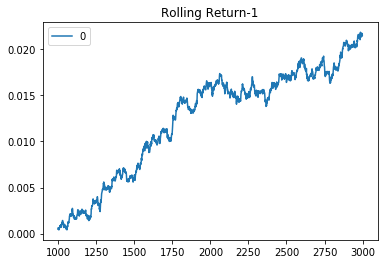

In [20]:
rolling_z = z.rolling(1000).mean()
rolling_plot = rolling_z.plot(title='Rolling Return-1')

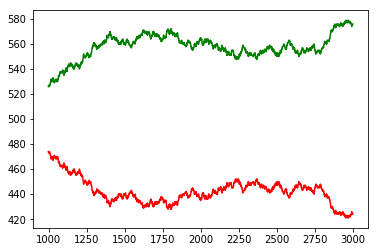

In [29]:
winning_trades = z.applymap(lambda x: 1 if x>0 else 0)
winning_trades_1000 = winning_trades.rolling(1000).sum()
losing_trades = z.applymap(lambda x: 1 if x<=0 else 0)
losing_trades_1000 = losing_trades.rolling(1000).sum()

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(winning_trades_1000.index,winning_trades_1000,color='green')
plt.plot(losing_trades_1000.index,losing_trades_1000,color='red')
plt.show()

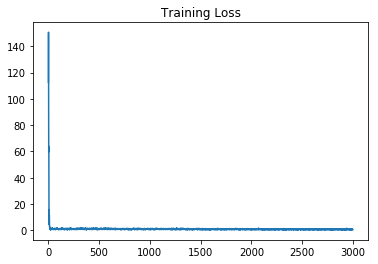

In [21]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

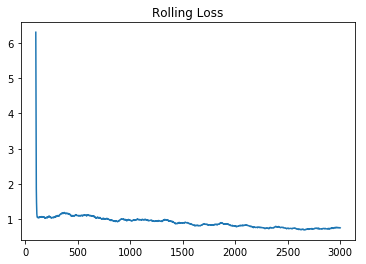

In [22]:
ep,reward = zip(*loss_list)
loss = pd.DataFrame(list(loss))
plt.plot(ep[:],loss.rolling(100).mean())
plt.title('Rolling Loss')
plt.show()

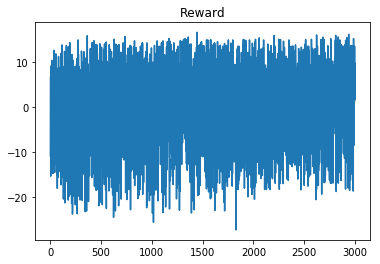

In [23]:
ep,reward = zip(*rewards_list)
plt.plot(ep[:],reward[:])
plt.title('Reward')
plt.show()

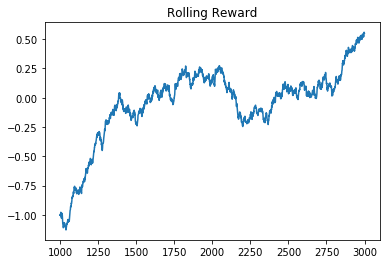

In [24]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
plt.plot(ep[:],reward.rolling(1000).mean())
plt.title('Rolling Reward')
plt.show()

Run episode with trained model:

In [25]:
def run_random(prices,pos_limit,trading_freq):
    
    actions = np.random.randint(0,3,size=len(prices))
    action_encoding = {0: 0, 1: 1, 2: -1}
    actions = [action_encoding[action] for action in actions]
    
    pos_log = []
    trade_log = []
    
    pos = 0
    window_counter = 0
    
    for action in actions:
        if action*pos>=0:
            if abs(pos) < pos_limit:
                trade_log.append(action)
                pos += action #increase existing position or apply action if flat or hold
            else:
                trade_log.append(0) 
        elif action*pos<0:
            trade_log.append(action*(abs(pos)+0))
            pos = 0 #action #close all existing positions and apply current action
        
        window_counter += trading_freq
    
    close_open_returns = prices.iloc[-1]['Close'] / prices.iloc[:window_counter+1]['Open']
    close_returns = [1+trade_log[i]*(close_open_returns[i]-1) for i in range(len(close_open_returns))]
                
    total_return = np.prod(close_returns)
    
    return total_return
    

In [26]:
def run_episode(env,pos_limit,trading_freq, verbose=1): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()
    i=0

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            #print('Day {:.0f} Open_day = {:.2f}, Close_epi = {:.2f}, Close_epi/Open_day = {:2f}, Trade = {:.0f}, Daily Return = {:.2f}'.format(i,info_log['prices'].iloc[i]['Open'],info_log['prices'].iloc[-1]['Close'],info_log['close_open_returns'][i],info_log['trades'][i],info_log['daily_return']))
            i += 1
            if done:
                break

    #run episode with random actions
    random_return = run_random(info_log['prices'],pos_limit,trading_freq)
                
    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    
    if verbose == 1:
        print('Return: {:.3f}'.format(info_log['total_return']))
        print('Random return: {:.3f}'.format(random_return))
    
        %matplotlib inline
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(15,3))
        #Plot Prices
        plt.xticks(rotation=90)
        plt.grid(color='k', linestyle='--', linewidth=0.1)
        plt.ylim(min(plt_df.Close)*0.98, max(plt_df.Close)*1.02)
        plt.plot(plt_df.index,plt_df.Close,color='black')
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Close,
                    color='green',marker='^',s=100,zorder=3)
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Close,
                    color='red',marker='v',s=100,zorder=3)

        for i, txt in enumerate(plt_df.Trades):
            if txt !=0:
                plt.annotate(txt, (plt_df.index[i], plt_df.Close[i]+0.008*plt_df.Close[i]))
                plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Close[i]-0.015*plt_df.Close[i]))

        plt.show()
    return info_log['total_return'], random_return

Return: 1.191
Random return: 1.170


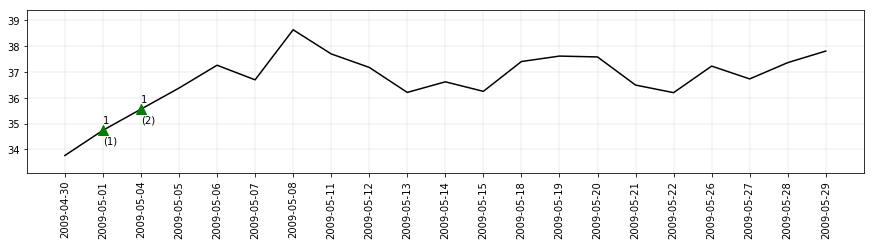

Return: 1.000
Random return: 1.039


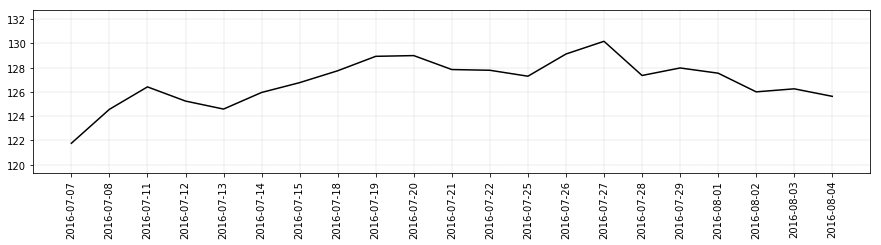

Return: 1.000
Random return: 0.945


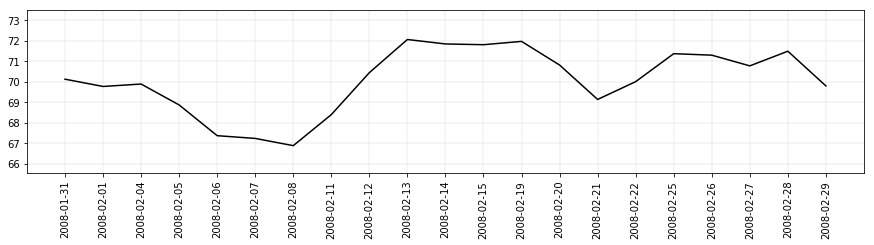

Return: 1.013
Random return: 1.044


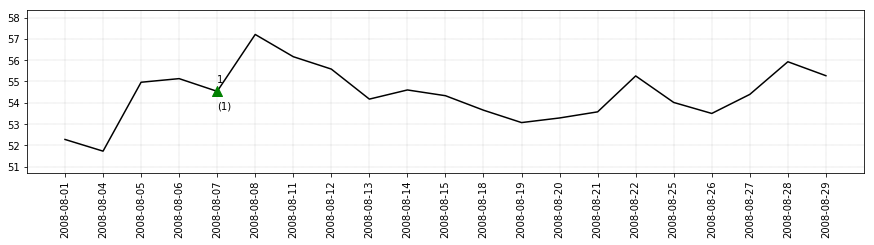

Return: 1.000
Random return: 0.950


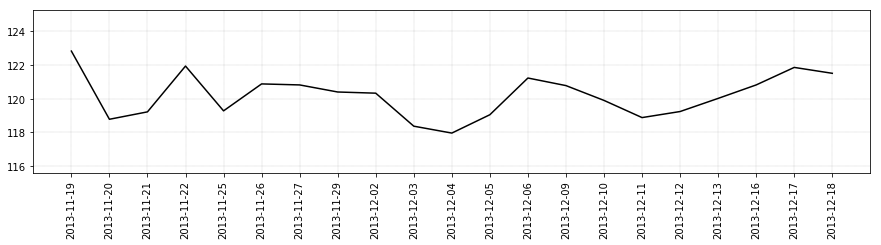

Return: 1.000
Random return: 1.125


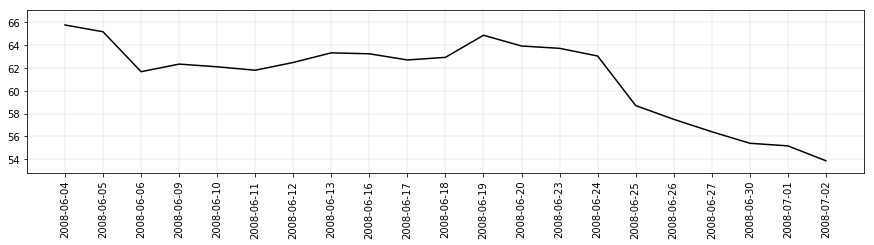

Return: 1.000
Random return: 1.054


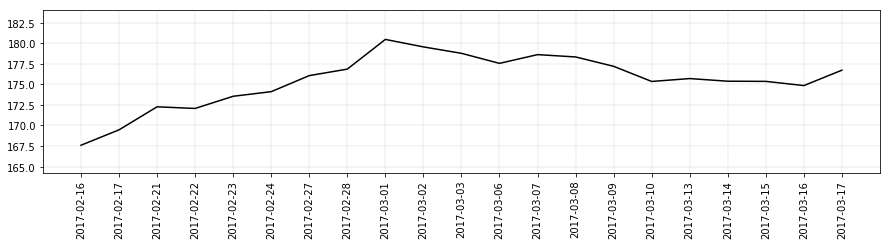

Return: 0.811
Random return: 1.033


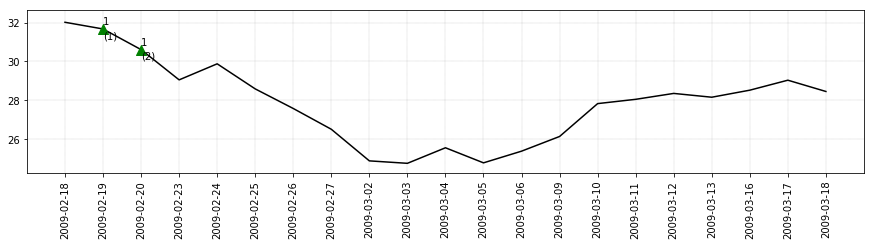

Return: 1.000
Random return: 0.882


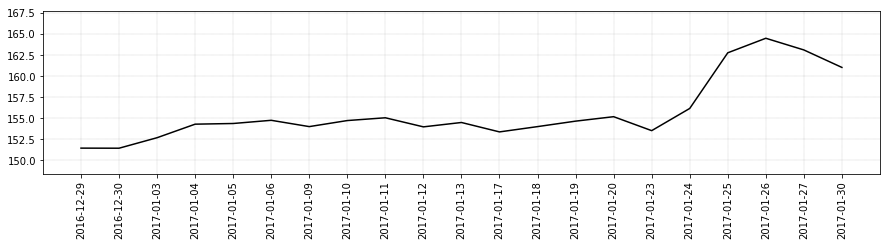

Return: 1.000
Random return: 0.856


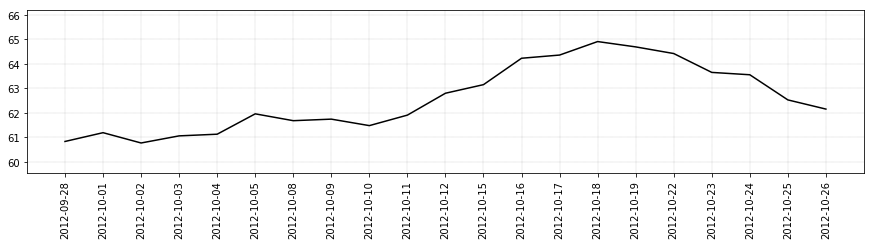

Return: 1.000
Random return: 0.915


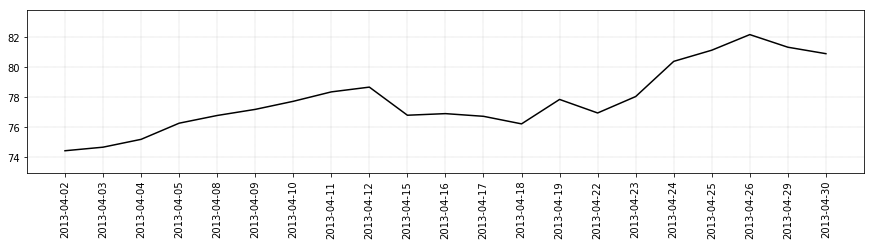

Return: 1.000
Random return: 1.156


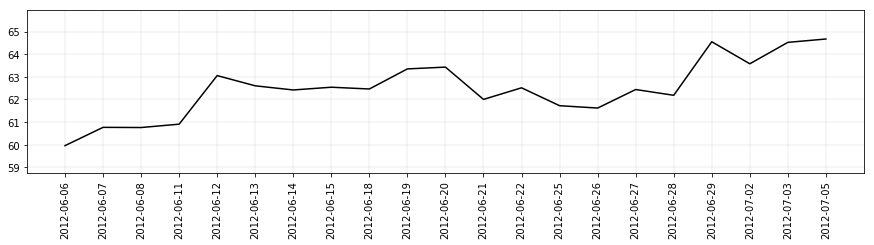

Return: 1.000
Random return: 0.951


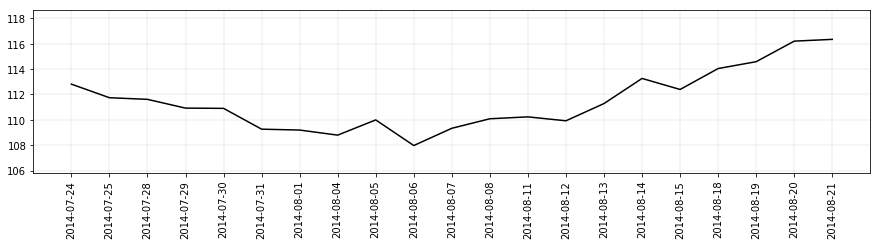

Return: 1.000
Random return: 1.137


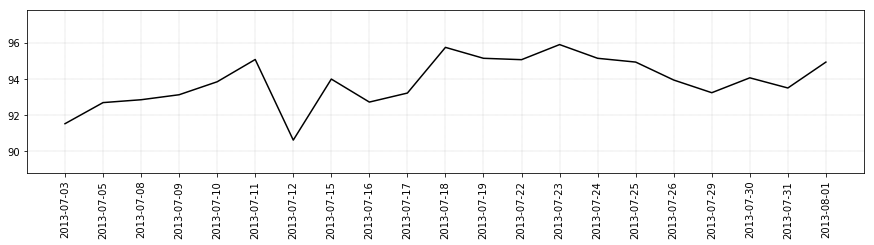

Return: 1.270
Random return: 0.839


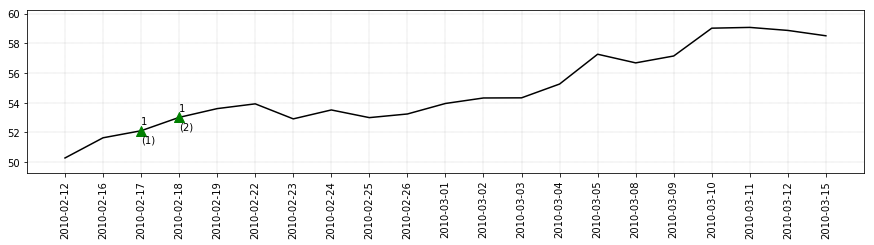

Average RL return: 1.019
Average random return: 1.006


In [28]:
episode_count = 15

returns = []
random_returns = []

for i in range(episode_count):
    return_, random_return = run_episode(env,pos_limit,trading_freq, verbose=1)
    returns.append(return_)
    random_returns.append(random_return)

print('Average RL return: {:.3f}'.format(np.mean(returns)))
print('Average random return: {:.3f}'.format(np.mean(random_returns)))